In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paleta Paper
BP_PRIMARY = '#0460D9'
BP_LIGHT   = "#1F93F97E"
BENCH_PRIMARY = "#FAA609"
BENCH_MEDIUM  = "#F0C35A"
DISC_PRIMARY = "#2CEC39"
DISC_LIGHT   = "#31C440"
REF_LIMIT = '#7f8c8d'

INPUT_FILE = 'prs.csv'

BOT_KEYWORDS = ['bot', 'dependabot', 'renovate', 'github-actions', 'codecov',
                'greenkeeper', 'snyk', 'pyup', 'automated', 'ci-', 'action',
                'github-advanced-security', 'copilot-pull-request']

def is_bot_author(author_name):
    if pd.isna(author_name):
        return False
    return any(kw in str(author_name).lower() for kw in BOT_KEYWORDS)

df_raw = pd.read_csv(INPUT_FILE)

df = df_raw[(df_raw['org'] == 'lappis-unb/decidimbr') & (df_raw['repo'] == 'decidim-govbr')].copy()
df_mds = df_raw[df_raw['org'] == 'unb-mds'].copy()
df_req = df_raw[df_raw['org'] == 'mdsreq-fga-unb'].copy()
df_decidim = df_raw[df_raw['org'] == 'decidim'].copy()
df_vscode = df_raw[df_raw['org'] == 'microsoft'].copy()

df_no_bots = df[~df['author'].apply(is_bot_author)].copy()
df_mds_no_bots = df_mds[~df_mds['author'].apply(is_bot_author)].copy()
df_req_no_bots = df_req[~df_req['author'].apply(is_bot_author)].copy()
df_decidim_no_bots = df_decidim[~df_decidim['author'].apply(is_bot_author)].copy()
df_vscode_no_bots = df_vscode[~df_vscode['author'].apply(is_bot_author)].copy()

org_title = "Brasil Participativo"
mds_title = "MDS Academic"
req_title = "REQ Academic"
vscode_title = "VSCode Market"
decidim_title = "Decidim Market"

print("📊 Dados carregados (total → sem bots):")
for name, full, filtered in [
    ("Brasil Participativo", df, df_no_bots),
    ("MDS", df_mds, df_mds_no_bots),
    ("REQ", df_req, df_req_no_bots),
    ("Decidim (benchmark)", df_decidim, df_decidim_no_bots),
    ("VSCode (benchmark)", df_vscode, df_vscode_no_bots),
]:
    removed = len(full) - len(filtered)
    pct = (removed / len(full) * 100) if len(full) > 0 else 0
    print(f"  {name:<25} {len(full):>6} → {len(filtered):>6}  ({removed} bots, {pct:.1f}%)")

📊 Dados carregados (total → sem bots):
  Brasil Participativo         510 →    510  (0 bots, 0.0%)
  MDS                          351 →    347  (4 bots, 1.1%)
  REQ                          231 →    231  (0 bots, 0.0%)
  Decidim (benchmark)         2172 →   1546  (626 bots, 28.8%)
  VSCode (benchmark)         15019 →  14944  (75 bots, 0.5%)


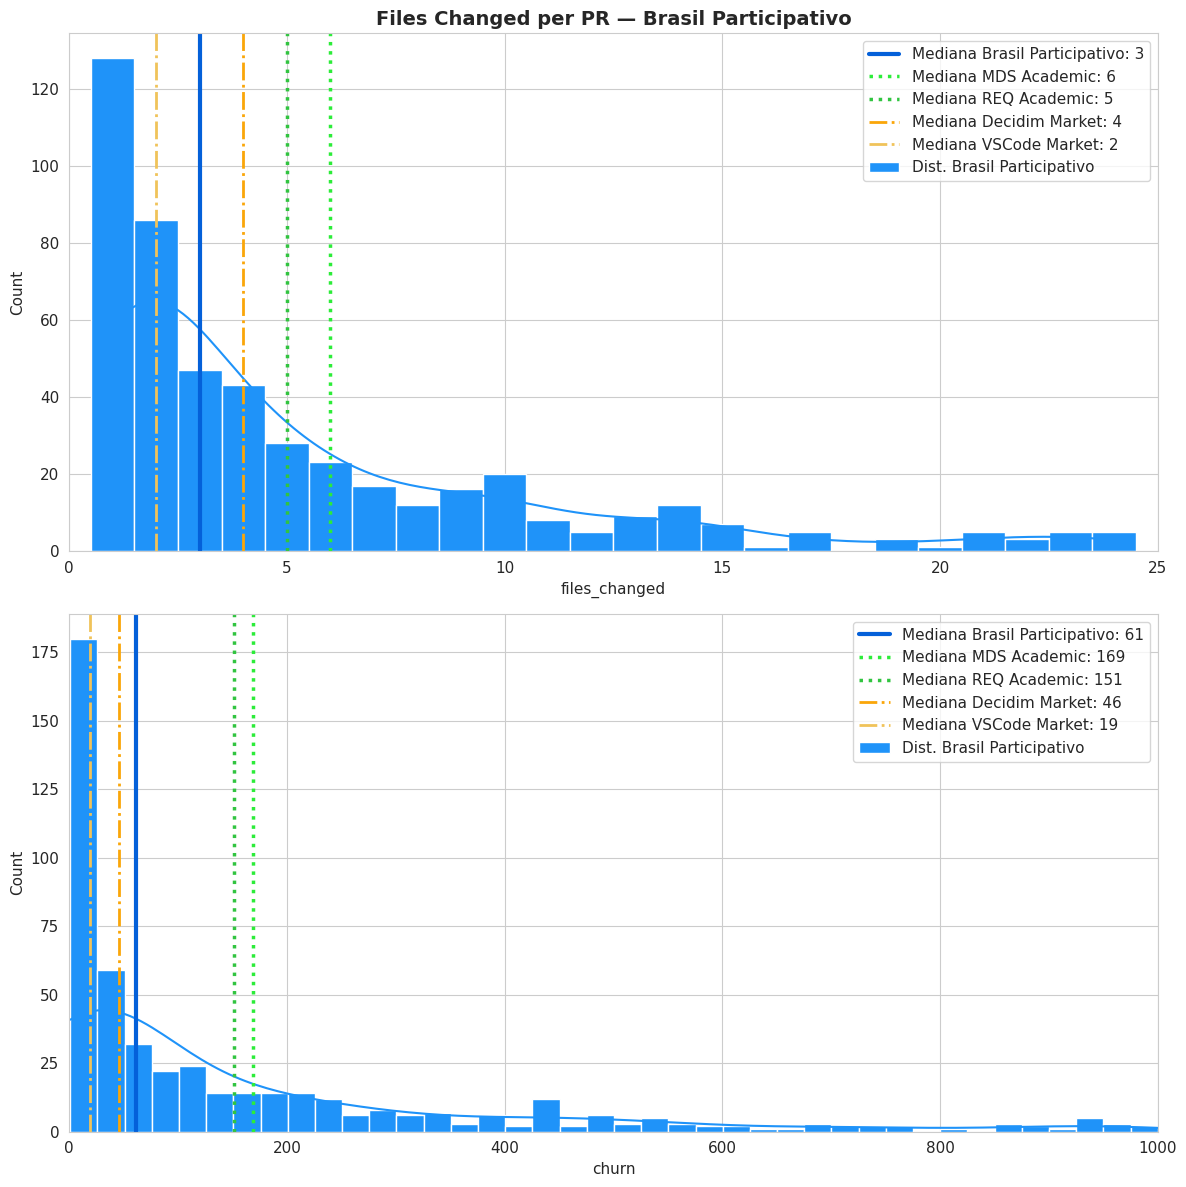

In [47]:
def plot_size_complexity_multi_bench(df_lab, df_mds, df_req, lab_label="BP", mds_label="MDS", req_label="Req"):
    clean_lab = df_lab[(df_lab['files_changed'] > 0) & (df_lab['churn'] > 0)].copy()
    clean_mds = df_mds[(df_mds['files_changed'] > 0) & (df_mds['churn'] > 0)].copy()
    clean_req = df_req[(df_req['files_changed'] > 0) & (df_req['churn'] > 0)].copy()
    clean_decidim = df_decidim_no_bots[(df_decidim_no_bots['files_changed'] > 0) & (df_decidim_no_bots['churn'] > 0)].copy()
    clean_vscode = df_vscode_no_bots[(df_vscode_no_bots['files_changed'] > 0) & (df_vscode_no_bots['churn'] > 0)].copy()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    p50_files_lab = clean_lab['files_changed'].median()
    p50_files_mds = clean_mds['files_changed'].median()
    p50_files_req = clean_req['files_changed'].median()
    p50_files_decidim = clean_decidim['files_changed'].median()
    p50_files_vscode = clean_vscode['files_changed'].median()
    p50_churn_lab = clean_lab['churn'].median()
    p50_churn_mds = clean_mds['churn'].median()
    p50_churn_req = clean_req['churn'].median()
    p50_churn_decidim = clean_decidim['churn'].median()
    p50_churn_vscode = clean_vscode['churn'].median()

    subset_files = clean_lab[clean_lab['files_changed'] <= 25]['files_changed']
    sns.histplot(subset_files, discrete=True, color=BP_LIGHT, edgecolor='white', alpha=1.0, ax=ax1, label=f'Dist. {lab_label}', kde=True)
    
    ax1.axvline(p50_files_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {p50_files_lab:.0f}')
    ax1.axvline(p50_files_mds, color=DISC_PRIMARY, linewidth=2.5, linestyle=':', label=f'Mediana {mds_label}: {p50_files_mds:.0f}')
    ax1.axvline(p50_files_req, color=DISC_LIGHT, linewidth=2.5, linestyle=':', label=f'Mediana {req_label}: {p50_files_req:.0f}')
    ax1.axvline(p50_files_decidim, color=BENCH_PRIMARY, linewidth=2, linestyle='-.', label=f'Mediana {decidim_title}: {p50_files_decidim:.0f}')
    ax1.axvline(p50_files_vscode, color=BENCH_MEDIUM, linewidth=2, linestyle='-.', label=f'Mediana {vscode_title}: {p50_files_vscode:.0f}')
    ax1.set_title('Files Changed per PR — Brasil Participativo', fontsize=14, fontweight='bold')
    ax1.set_xlim(0, 25)
    ax1.legend()

    subset_churn = clean_lab[clean_lab['churn'] <= 1000]['churn']
    sns.histplot(subset_churn, binwidth=25, kde=True, color=BP_LIGHT, edgecolor='white', alpha=1.0, ax=ax2, label=f'Dist. {lab_label}')
    
    ax2.axvline(p50_churn_lab, color=BP_PRIMARY, linewidth=3, label=f'Mediana {lab_label}: {p50_churn_lab:.0f}')
    ax2.axvline(p50_churn_mds, color=DISC_PRIMARY, linewidth=2.5, linestyle=':', label=f'Mediana {mds_label}: {p50_churn_mds:.0f}')
    ax2.axvline(p50_churn_req, color=DISC_LIGHT, linewidth=2.5, linestyle=':', label=f'Mediana {req_label}: {p50_churn_req:.0f}')
    ax2.axvline(p50_churn_decidim, color=BENCH_PRIMARY, linewidth=2, linestyle='-.', label=f'Mediana {decidim_title}: {p50_churn_decidim:.0f}')
    ax2.axvline(p50_churn_vscode, color=BENCH_MEDIUM, linewidth=2, linestyle='-.', label=f'Mediana {vscode_title}: {p50_churn_vscode:.0f}')
    ax2.set_xlim(0, 1000)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_size_complexity_multi_bench(df_no_bots, df_mds_no_bots, df_req_no_bots, lab_label=org_title, mds_label=mds_title, req_label=req_title)

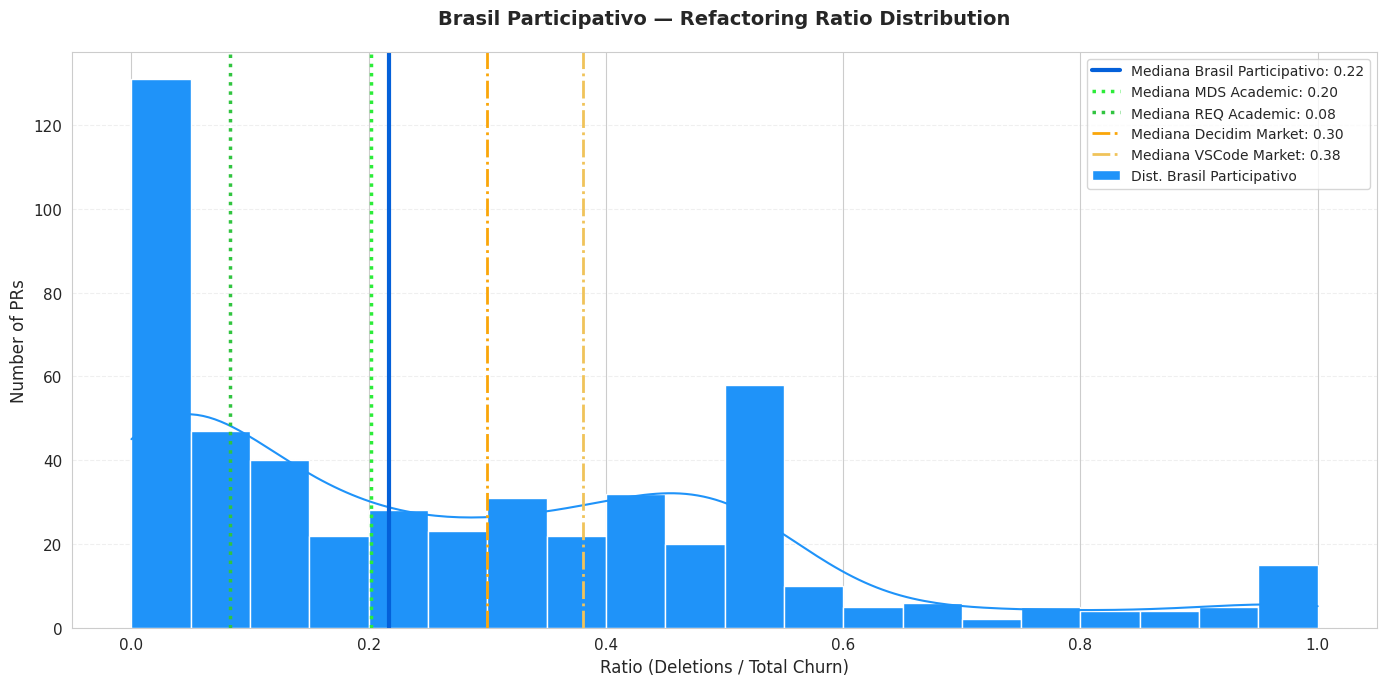

In [48]:
def plot_maintenance_patterns_comparison(df_bp, df_mds, df_req):
    def calculate_ratio(data):
        temp = data.copy()
        temp['refactor_ratio'] = temp.apply(lambda x: x['deletions'] / x['churn'] if x['churn'] > 0 else 0, axis=1)
        return temp

    df_bp_final = calculate_ratio(df_bp)
    df_mds_final = calculate_ratio(df_mds)
    df_req_final = calculate_ratio(df_req)
    df_decidim_final = calculate_ratio(df_decidim_no_bots)
    df_vscode_final = calculate_ratio(df_vscode_no_bots)

    med_bp = df_bp_final['refactor_ratio'].median()
    med_mds = df_mds_final['refactor_ratio'].median()
    med_req = df_req_final['refactor_ratio'].median()
    med_decidim = df_decidim_final['refactor_ratio'].median()
    med_vscode = df_vscode_final['refactor_ratio'].median()

    fig, ax = plt.subplots(figsize=(14, 7))
    
    sns.histplot(df_bp_final['refactor_ratio'], kde=True, color=BP_LIGHT, edgecolor='white', 
                 bins=20, ax=ax, alpha=1.0, label=f'Dist. {org_title}')
    
    ax.axvline(med_bp, color=BP_PRIMARY, linewidth=3, label=f'Mediana {org_title}: {med_bp:.2f}')
    ax.axvline(med_mds, color=DISC_PRIMARY, linewidth=2.5, linestyle=':', label=f'Mediana {mds_title}: {med_mds:.2f}')
    ax.axvline(med_req, color=DISC_LIGHT, linewidth=2.5, linestyle=':', label=f'Mediana {req_title}: {med_req:.2f}')
    ax.axvline(med_decidim, color=BENCH_PRIMARY, linewidth=2, linestyle='-.', label=f'Mediana {decidim_title}: {med_decidim:.2f}')
    ax.axvline(med_vscode, color=BENCH_MEDIUM, linewidth=2, linestyle='-.', label=f'Mediana {vscode_title}: {med_vscode:.2f}')
    
    ax.set_title(f'{org_title} — Refactoring Ratio Distribution', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Ratio (Deletions / Total Churn)', fontsize=12)
    ax.set_ylabel('Number of PRs', fontsize=12)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_maintenance_patterns_comparison(df_no_bots, df_mds_no_bots, df_req_no_bots)

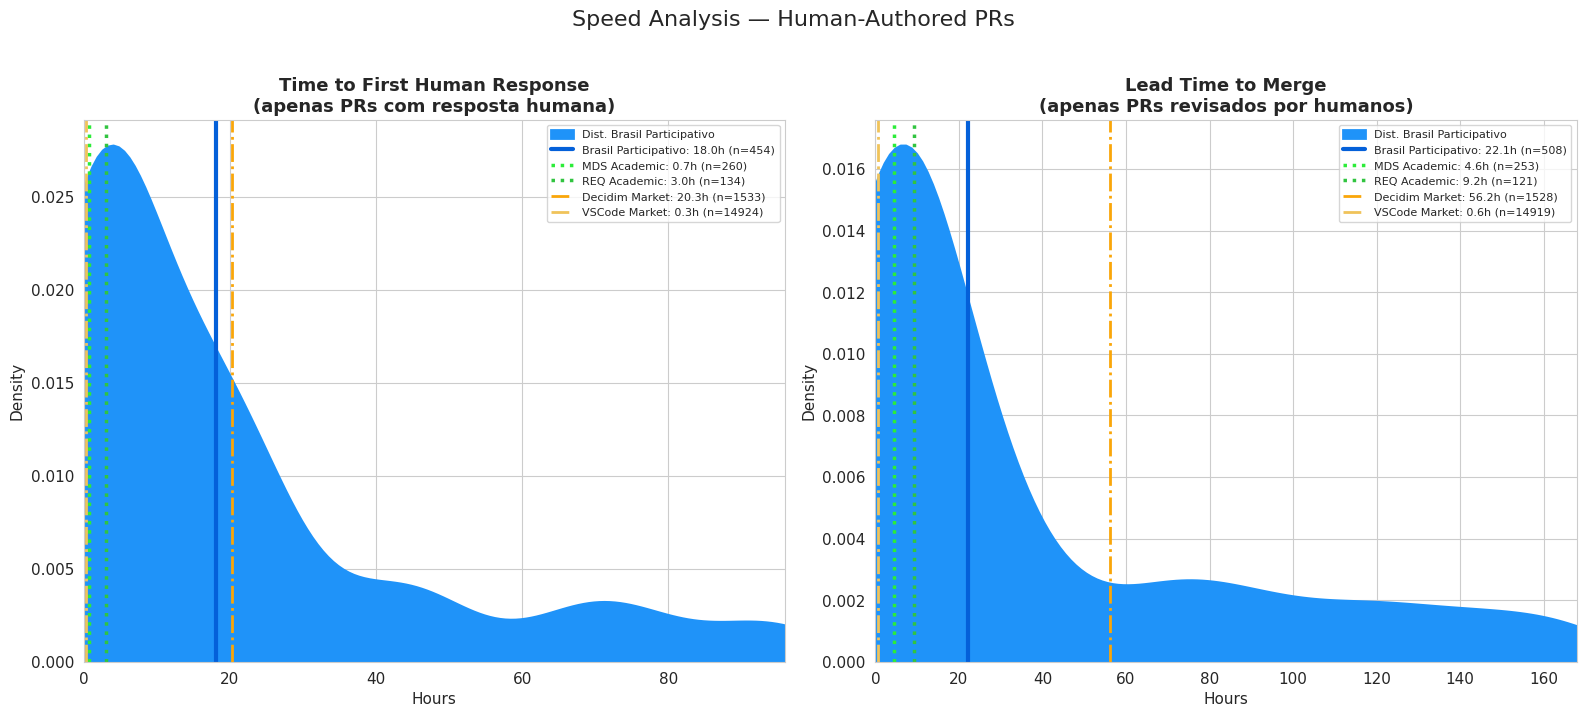

In [49]:
def count_human_reviewers_for_filter(reviewers_str):
    """Conta apenas reviewers humanos (exclui bots conhecidos)"""
    if pd.isna(reviewers_str) or reviewers_str == "":
        return 0
    reviewers = [r.strip() for r in str(reviewers_str).split(',')]
    return sum(1 for r in reviewers if not is_bot_author(r))

def plot_review_speed_all_values(df_lab, df_mds, df_req, lab_label="BP", mds_label="MDS", req_label="Req"):
    """
    Gráfico 1: Time to First Human Response — apenas PRs que TIVERAM resposta humana.
    Gráfico 2: Lead Time — apenas PRs que foram REVISADOS por humanos.
    Ambos usam apenas PRs de autores humanos.
    """
    
    time_col = 'time_to_first_human_response_hours'
    if time_col not in df_lab.columns:
        time_col = 'time_to_first_review_hours'
    
    # Filtra APENAS PRs que tiveram resposta humana (campo preenchido e > 0)
    resp_lab = df_lab[df_lab[time_col].notna() & (df_lab[time_col] > 0)][time_col]
    resp_mds = df_mds[df_mds[time_col].notna() & (df_mds[time_col] > 0)][time_col]
    resp_req = df_req[df_req[time_col].notna() & (df_req[time_col] > 0)][time_col]
    resp_decidim = df_decidim_no_bots[df_decidim_no_bots[time_col].notna() & (df_decidim_no_bots[time_col] > 0)][time_col]
    resp_vscode = df_vscode_no_bots[df_vscode_no_bots[time_col].notna() & (df_vscode_no_bots[time_col] > 0)][time_col]
    
    def filter_human_reviewed(data):
        has_human_reviewer = data['reviewers'].apply(count_human_reviewers_for_filter) > 0
        has_lead_time = data['lead_time_hours'].notna() & (data['lead_time_hours'] > 0)
        return data[has_human_reviewer & has_lead_time]['lead_time_hours']
    
    comp_lab = filter_human_reviewed(df_lab)
    comp_mds = filter_human_reviewed(df_mds)
    comp_req = filter_human_reviewed(df_req)
    comp_decidim = filter_human_reviewed(df_decidim_no_bots)
    comp_vscode = filter_human_reviewed(df_vscode_no_bots)
    
    # ==================== PLOT ====================
    viz_resp_lab = resp_lab[resp_lab <= 96]
    viz_comp_lab = comp_lab[comp_lab <= 168]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # --- Gráfico 1: BP em destaque (100%), benchmarks e disciplinas em 60% ---
    sns.kdeplot(viz_resp_lab, fill=True, color=BP_LIGHT, alpha=1.0, linewidth=2, ax=ax1, label=f'Dist. {lab_label}')
    
    med_resp_lab = resp_lab.median()
    med_resp_mds = resp_mds.median()
    med_resp_req = resp_req.median()
    med_resp_decidim = resp_decidim.median()
    med_resp_vscode = resp_vscode.median()
    
    ax1.axvline(med_resp_lab, color=BP_PRIMARY, linewidth=3, label=f'{lab_label}: {med_resp_lab:.1f}h (n={len(resp_lab)})')
    ax1.axvline(med_resp_mds, color=DISC_PRIMARY, linewidth=2.5, linestyle=':', label=f'{mds_label}: {med_resp_mds:.1f}h (n={len(resp_mds)})')
    ax1.axvline(med_resp_req, color=DISC_LIGHT, linewidth=2.5, linestyle=':', label=f'{req_label}: {med_resp_req:.1f}h (n={len(resp_req)})')
    ax1.axvline(med_resp_decidim, color=BENCH_PRIMARY, linewidth=2, linestyle='-.', label=f'{decidim_title}: {med_resp_decidim:.1f}h (n={len(resp_decidim)})')
    ax1.axvline(med_resp_vscode, color=BENCH_MEDIUM, linewidth=2, linestyle='-.', label=f'{vscode_title}: {med_resp_vscode:.1f}h (n={len(resp_vscode)})')
    ax1.set_title('Time to First Human Response\n(apenas PRs com resposta humana)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Hours')
    ax1.set_xlim(0, 96)
    ax1.legend(fontsize=8)

    # --- Gráfico 2 ---
    sns.kdeplot(viz_comp_lab, fill=True, color=BP_LIGHT, alpha=1.0, linewidth=2, ax=ax2, label=f'Dist. {lab_label}')
    
    med_comp_lab = comp_lab.median()
    med_comp_mds = comp_mds.median()
    med_comp_req = comp_req.median()
    med_comp_decidim = comp_decidim.median()
    med_comp_vscode = comp_vscode.median()
    
    ax2.axvline(med_comp_lab, color=BP_PRIMARY, linewidth=3, label=f'{lab_label}: {med_comp_lab:.1f}h (n={len(comp_lab)})')
    ax2.axvline(med_comp_mds, color=DISC_PRIMARY, linewidth=2.5, linestyle=':', label=f'{mds_label}: {med_comp_mds:.1f}h (n={len(comp_mds)})')
    ax2.axvline(med_comp_req, color=DISC_LIGHT, linewidth=2.5, linestyle=':', label=f'{req_label}: {med_comp_req:.1f}h (n={len(comp_req)})')
    ax2.axvline(med_comp_decidim, color=BENCH_PRIMARY, linewidth=2, linestyle='-.', label=f'{decidim_title}: {med_comp_decidim:.1f}h (n={len(comp_decidim)})')
    ax2.axvline(med_comp_vscode, color=BENCH_MEDIUM, linewidth=2, linestyle='-.', label=f'{vscode_title}: {med_comp_vscode:.1f}h (n={len(comp_vscode)})')
    ax2.set_title('Lead Time to Merge\n(apenas PRs revisados por humanos)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Hours')
    ax2.set_xlim(0, 168)
    ax2.legend(fontsize=8)
    
    plt.suptitle("Speed Analysis — Human-Authored PRs", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_review_speed_all_values(df_no_bots, df_mds_no_bots, df_req_no_bots, lab_label=org_title, mds_label=mds_title, req_label=req_title)

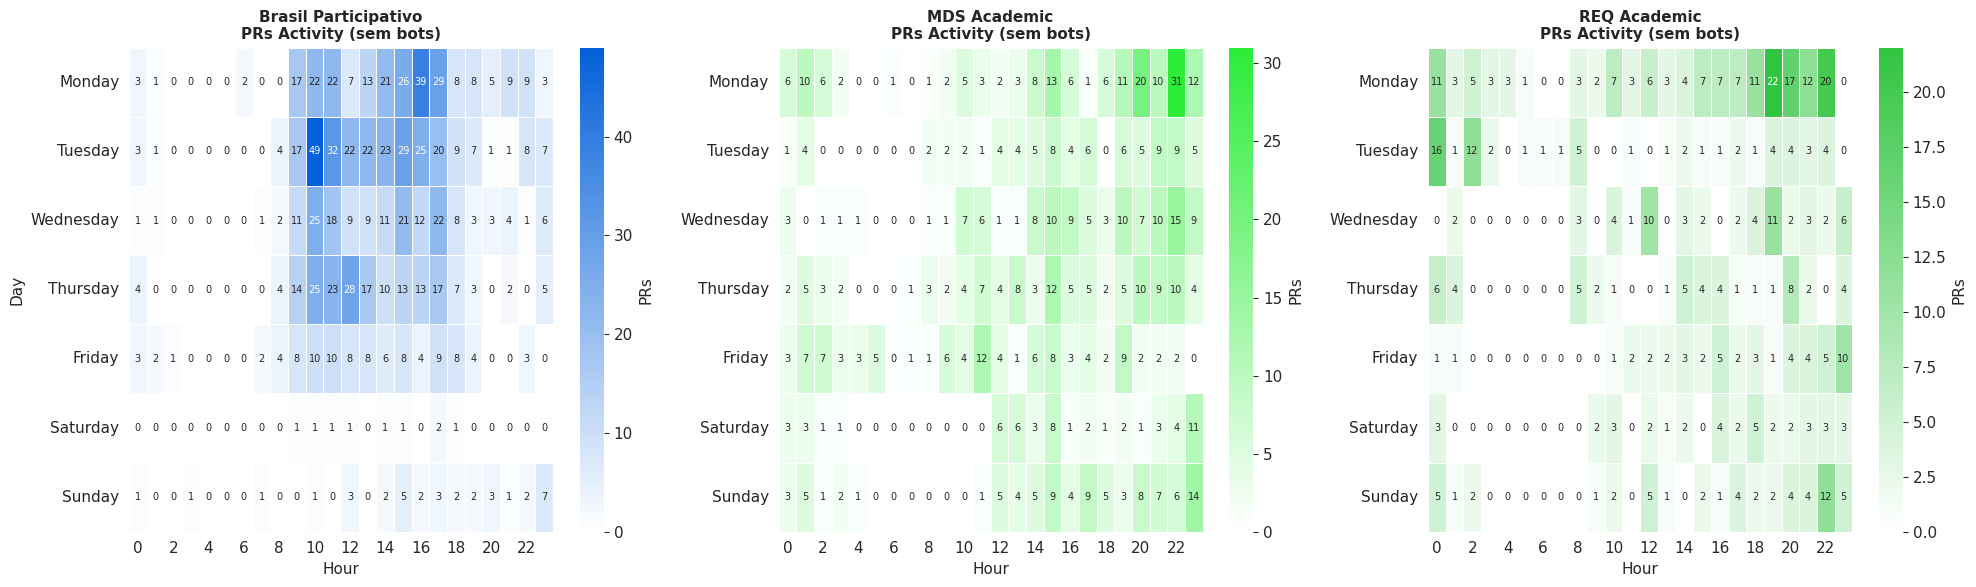

In [50]:
def plot_activity_heatmaps_comparison(df_bp, df_mds, df_req):
    def prepare_data(data):
        data = data.copy()
        data['created_at'] = pd.to_datetime(data['created_at'], utc=True)
        data['merged_at'] = pd.to_datetime(data['merged_at'], utc=True)
        try:
            data['created_at_br'] = data['created_at'].dt.tz_convert('America/Sao_Paulo')
            data['merged_at_br'] = data['merged_at'].dt.tz_convert('America/Sao_Paulo')
        except:
            data['created_at_br'] = data['created_at']
            data['merged_at_br'] = data['merged_at']
        return data

    def get_combined_heatmap_data(data):
        temp_created = data[['id', 'created_at_br']].dropna().copy()
        temp_created['day_name'] = temp_created['created_at_br'].dt.day_name()
        temp_created['hour'] = temp_created['created_at_br'].dt.hour
        
        temp_merged = data[['id', 'merged_at_br']].dropna().copy()
        temp_merged['day_name'] = temp_merged['merged_at_br'].dt.day_name()
        temp_merged['hour'] = temp_merged['merged_at_br'].dt.hour
        
        temp_combined = pd.concat([
            temp_created[['day_name', 'hour']], 
            temp_merged[['day_name', 'hour']]
        ])
        
        pivot = temp_combined.groupby(['day_name', 'hour']).size().unstack(fill_value=0)
        days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot = pivot.reindex(days_order).fillna(0).astype(int)
        for h in range(24):
            if h not in pivot.columns:
                pivot[h] = 0
        return pivot[sorted(pivot.columns)]

    cmap_bp = LinearSegmentedColormap.from_list("bp", ["#ffffff", BP_PRIMARY])
    cmap_mds = LinearSegmentedColormap.from_list("mds", ["#ffffff", DISC_PRIMARY])
    cmap_req = LinearSegmentedColormap.from_list("req", ["#ffffff", DISC_LIGHT])

    df_bp = prepare_data(df_bp)
    df_mds = prepare_data(df_mds)
    df_req = prepare_data(df_req)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    sns.heatmap(get_combined_heatmap_data(df_bp), cmap=cmap_bp, annot=True, fmt='d', linewidths=.5, ax=axes[0], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[0].set_title(f'{org_title}\nPRs Activity (sem bots)', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_combined_heatmap_data(df_mds), cmap=cmap_mds, annot=True, fmt='d', linewidths=.5, ax=axes[1], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[1].set_title(f'{mds_title}\nPRs Activity (sem bots)', fontsize=11, fontweight='bold')
    
    sns.heatmap(get_combined_heatmap_data(df_req), cmap=cmap_req, annot=True, fmt='d', linewidths=.5, ax=axes[2], cbar_kws={'label': 'PRs'}, annot_kws={'size': 7})
    axes[2].set_title(f'{req_title}\nPRs Activity (sem bots)', fontsize=11, fontweight='bold')

    for ax in axes.flat:
        ax.set_ylabel('')
        ax.set_xlabel('Hour')
    axes[0].set_ylabel('Day')

    plt.tight_layout()
    plt.show()

plot_activity_heatmaps_comparison(df_no_bots, df_mds_no_bots, df_req_no_bots)

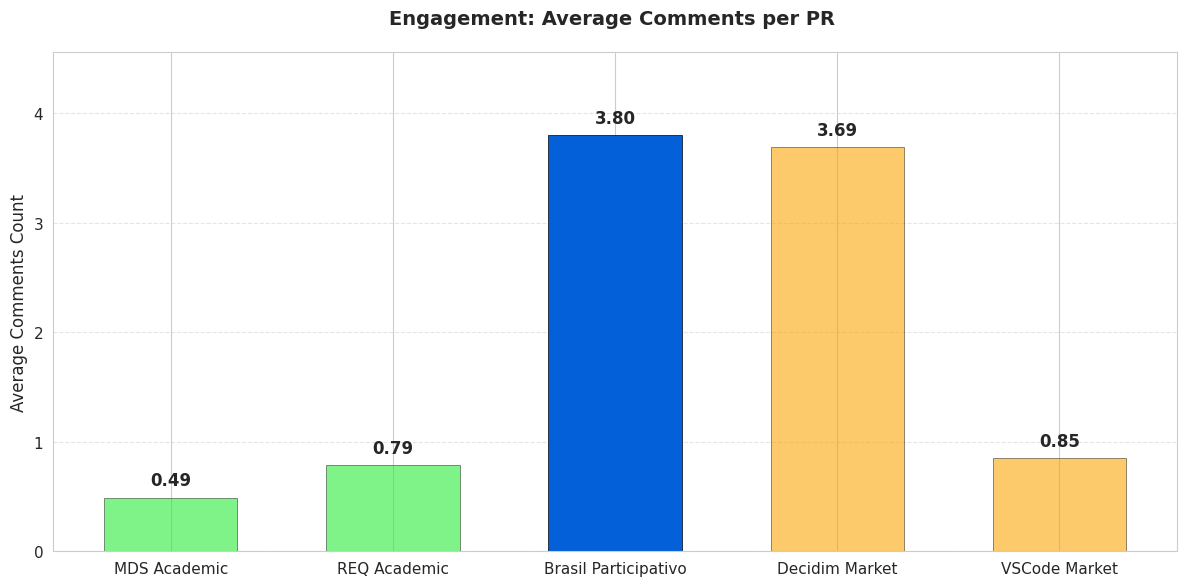

In [51]:
avg_comments_bp = df_no_bots['comments'].mean()
avg_comments_mds = df_mds_no_bots['comments'].mean()
avg_comments_req = df_req_no_bots['comments'].mean()
avg_comments_decidim = df_decidim_no_bots['comments'].mean()
avg_comments_vscode = df_vscode_no_bots['comments'].mean()

x_labels = [mds_title, req_title, org_title, decidim_title, vscode_title]
y_values = [avg_comments_mds, avg_comments_req, avg_comments_bp, avg_comments_decidim, avg_comments_vscode]
bar_colors = [DISC_PRIMARY, DISC_PRIMARY, BP_PRIMARY, BENCH_PRIMARY, BENCH_PRIMARY]
bar_alphas = [0.6, 0.6, 1.0, 0.6, 0.6]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x_labels, y_values, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars, bar_alphas):
    bar.set_alpha(alpha)

ax.set_title('Engagement: Average Comments per PR ', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Average Comments Count', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(y_values) * 0.02),
            f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylim(0, max(y_values) * 1.2)
plt.tight_layout()
plt.show()

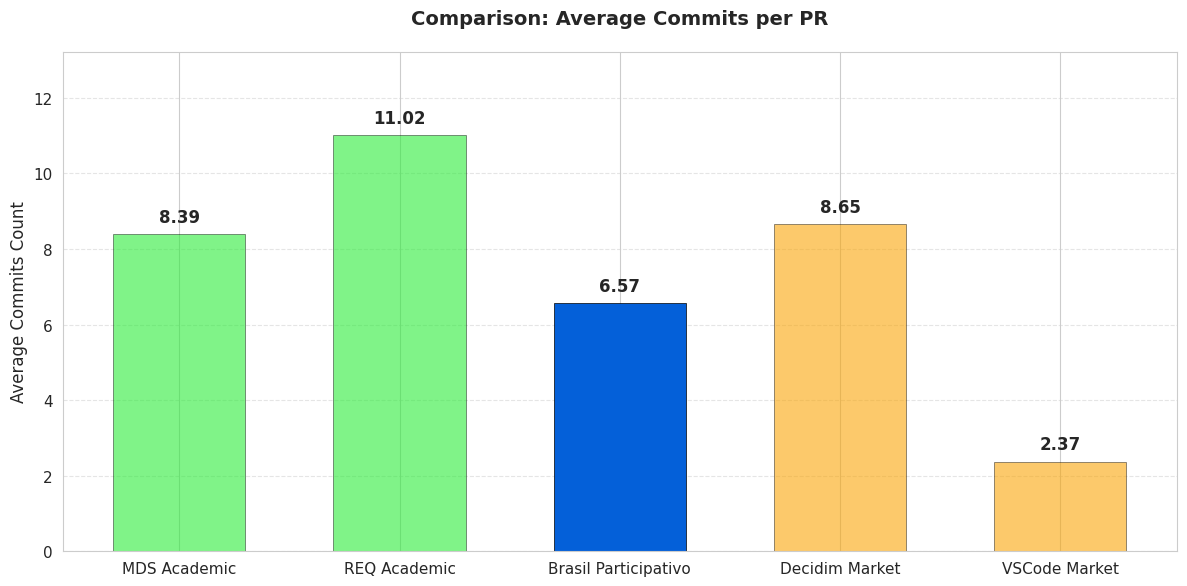

In [52]:
avg_commits_bp = df_no_bots['commits'].mean()
avg_commits_mds = df_mds_no_bots['commits'].mean()
avg_commits_req = df_req_no_bots['commits'].mean()
avg_commits_decidim = df_decidim_no_bots['commits'].mean()
avg_commits_vscode = df_vscode_no_bots['commits'].mean()

x_labels = [mds_title, req_title, org_title, decidim_title, vscode_title]
y_values = [avg_commits_mds, avg_commits_req, avg_commits_bp, avg_commits_decidim, avg_commits_vscode]
bar_colors = [DISC_PRIMARY, DISC_PRIMARY, BP_PRIMARY, BENCH_PRIMARY, BENCH_PRIMARY]
bar_alphas = [0.6, 0.6, 1.0, 0.6, 0.6]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x_labels, y_values, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars, bar_alphas):
    bar.set_alpha(alpha)

ax.set_title('Comparison: Average Commits per PR', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Average Commits Count', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(y_values) * 0.02),
            f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylim(0, max(y_values) * 1.2)
plt.tight_layout()
plt.show()

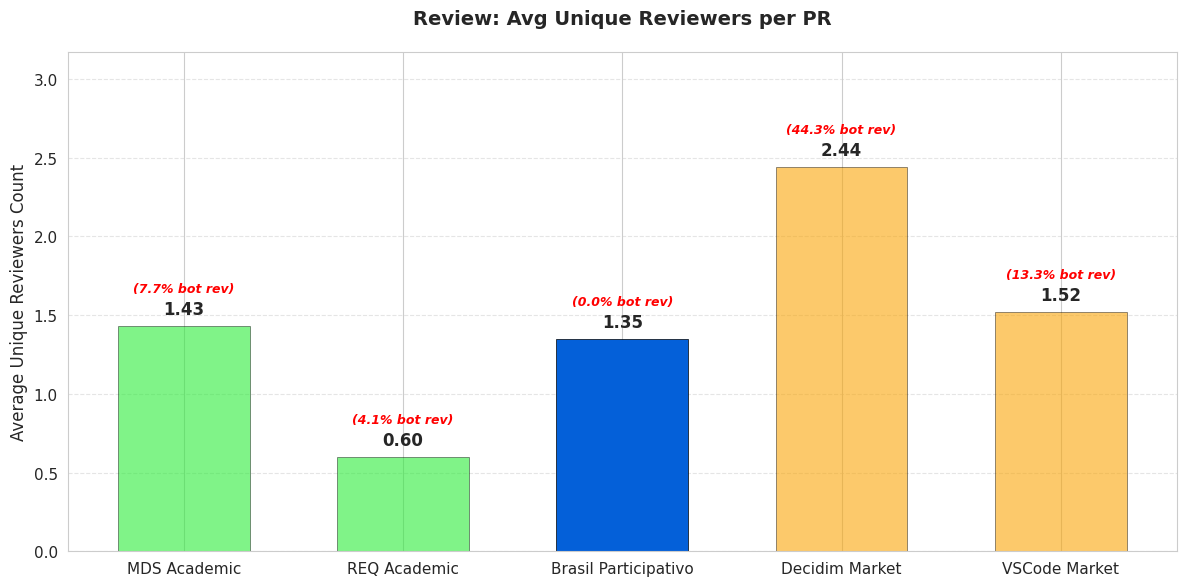

In [53]:
def count_unique_reviewers(reviewers_str):
    if pd.isna(reviewers_str) or reviewers_str == '':
        return 0
    return len(str(reviewers_str).split(','))

def count_bot_reviewers(reviewers_str):
    if pd.isna(reviewers_str) or reviewers_str == '':
        return 0
    bot_kw = ['github-actions', 'github-advanced-security', 'copilot-pull-request-reviewer',
              'dependabot', 'renovate', 'codecov']
    reviewers = [r.strip().lower() for r in str(reviewers_str).split(',')]
    return sum(1 for r in reviewers if any(bot in r for bot in bot_kw))

for d in [df_no_bots, df_mds_no_bots, df_req_no_bots, df_decidim_no_bots, df_vscode_no_bots]:
    d['num_reviewers'] = d['reviewers'].apply(count_unique_reviewers)

df_rev_bp = df_no_bots[df_no_bots['reviewers'].notna() & (df_no_bots['reviewers'] != '')].copy()
df_rev_mds = df_mds_no_bots[df_mds_no_bots['reviewers'].notna() & (df_mds_no_bots['reviewers'] != '')].copy()
df_rev_req = df_req_no_bots[df_req_no_bots['reviewers'].notna() & (df_req_no_bots['reviewers'] != '')].copy()
df_rev_decidim = df_decidim_no_bots[df_decidim_no_bots['reviewers'].notna() & (df_decidim_no_bots['reviewers'] != '')].copy()
df_rev_vscode = df_vscode_no_bots[df_vscode_no_bots['reviewers'].notna() & (df_vscode_no_bots['reviewers'] != '')].copy()

bot_reviewers_bp = df_rev_bp['reviewers'].apply(count_bot_reviewers).mean() if len(df_rev_bp) > 0 else 0
bot_reviewers_mds = df_rev_mds['reviewers'].apply(count_bot_reviewers).mean() if len(df_rev_mds) > 0 else 0
bot_reviewers_req = df_rev_req['reviewers'].apply(count_bot_reviewers).mean() if len(df_rev_req) > 0 else 0
bot_reviewers_decidim = df_rev_decidim['reviewers'].apply(count_bot_reviewers).mean() if len(df_rev_decidim) > 0 else 0
bot_reviewers_vscode = df_rev_vscode['reviewers'].apply(count_bot_reviewers).mean() if len(df_rev_vscode) > 0 else 0

avg_unique_reviewers_bp = df_no_bots['num_reviewers'].mean()
avg_unique_reviewers_mds = df_mds_no_bots['num_reviewers'].mean()
avg_unique_reviewers_req = df_req_no_bots['num_reviewers'].mean()
avg_unique_reviewers_decidim = df_decidim_no_bots['num_reviewers'].mean()
avg_unique_reviewers_vscode = df_vscode_no_bots['num_reviewers'].mean()

x_labels = [mds_title, req_title, org_title, decidim_title, vscode_title]
total_values = [avg_unique_reviewers_mds, avg_unique_reviewers_req, avg_unique_reviewers_bp,
                avg_unique_reviewers_decidim, avg_unique_reviewers_vscode]
bot_values = [bot_reviewers_mds, bot_reviewers_req, bot_reviewers_bp,
              bot_reviewers_decidim, bot_reviewers_vscode]
bar_colors = [DISC_PRIMARY, DISC_PRIMARY, BP_PRIMARY, BENCH_PRIMARY, BENCH_PRIMARY]
bar_alphas = [0.6, 0.6, 1.0, 0.6, 0.6]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(x_labels, total_values, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars, bar_alphas):
    bar.set_alpha(alpha)

ax.set_title('Review: Avg Unique Reviewers per PR', fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Average Unique Reviewers Count', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)

for i, (bar, total, bot) in enumerate(zip(bars, total_values, bot_values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(total_values) * 0.02),
            f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    bot_pct = (bot / total * 100) if total > 0 else 0
    ax.text(bar.get_x() + bar.get_width()/2., height + (max(total_values) * 0.08),
            f'({bot_pct:.1f}% bot rev)', ha='center', va='bottom', fontsize=9,
            color='red', style='italic', fontweight='bold')

ax.set_ylim(0, max(total_values) * 1.3)
plt.tight_layout()
plt.show()

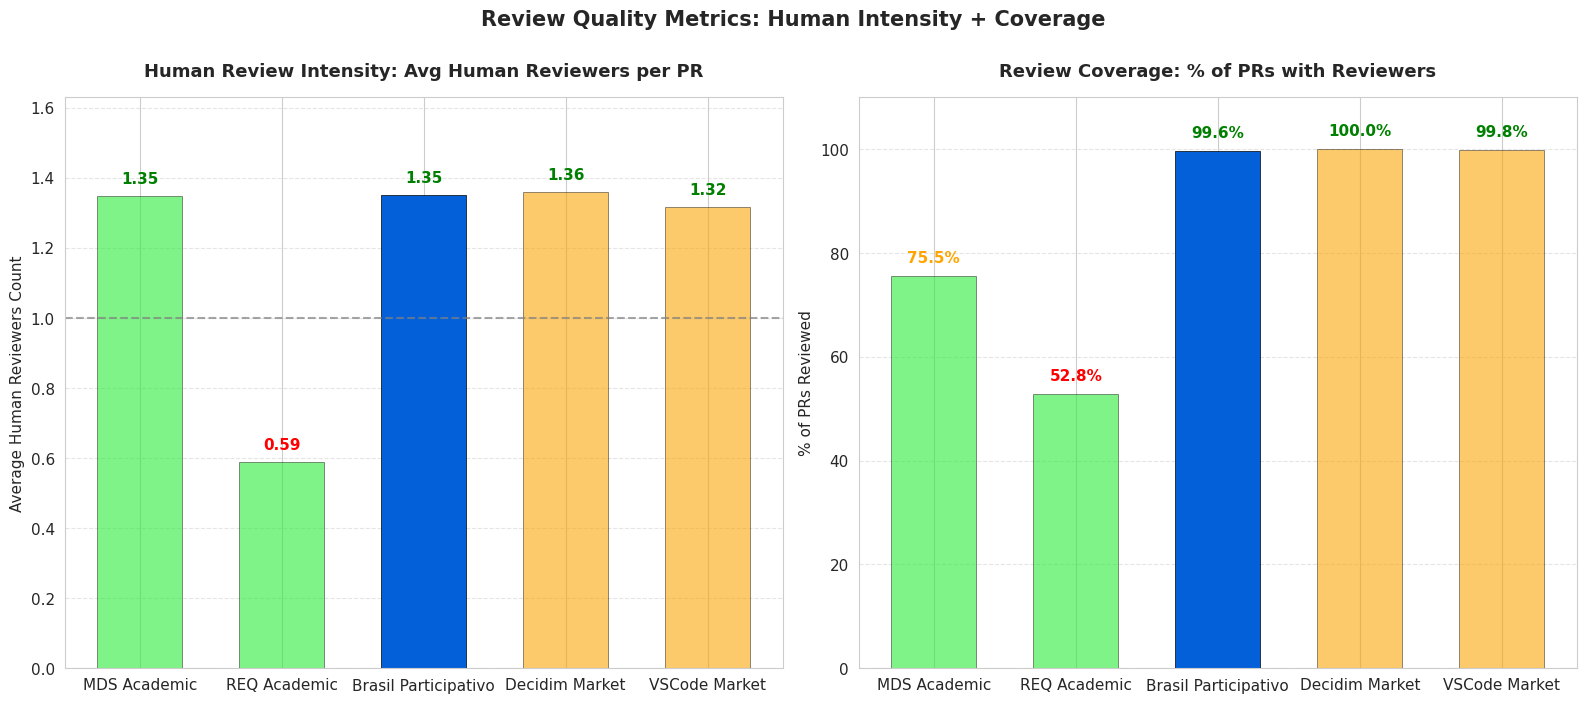

In [54]:
def count_human_and_bot_reviewers(reviewers_str):
    """Retorna (humanos, bots) contados na string de reviewers"""
    if pd.isna(reviewers_str) or reviewers_str == '':
        return 0, 0
    reviewers = [r.strip() for r in str(reviewers_str).split(',')]
    humans = 0
    bots = 0
    for r in reviewers:
        if any(kw in r.lower() for kw in BOT_KEYWORDS):
            bots += 1
        else:
            humans += 1
    return humans, bots

def get_human_reviewer_count(reviewers_str):
    """Retorna apenas o count de reviewers humanos"""
    humans, _ = count_human_and_bot_reviewers(reviewers_str)
    return humans

for d in [df_no_bots, df_mds_no_bots, df_req_no_bots, df_decidim_no_bots, df_vscode_no_bots]:
    d['human_reviewers_count'] = d['reviewers'].apply(get_human_reviewer_count)

def calc_coverage(df):
    has_reviewers = (df['reviewers'].notna() & (df['reviewers'] != '')).sum()
    return (has_reviewers / len(df) * 100) if len(df) > 0 else 0

def calc_human_intensity(df):
    return df['human_reviewers_count'].mean() if len(df) > 0 else 0

coverage_bp = calc_coverage(df_no_bots)
coverage_mds = calc_coverage(df_mds_no_bots)
coverage_req = calc_coverage(df_req_no_bots)
coverage_decidim = calc_coverage(df_decidim_no_bots)
coverage_vscode = calc_coverage(df_vscode_no_bots)

human_intensity_bp = calc_human_intensity(df_no_bots)
human_intensity_mds = calc_human_intensity(df_mds_no_bots)
human_intensity_req = calc_human_intensity(df_req_no_bots)
human_intensity_decidim = calc_human_intensity(df_decidim_no_bots)
human_intensity_vscode = calc_human_intensity(df_vscode_no_bots)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

x_labels = [mds_title, req_title, org_title, decidim_title, vscode_title]
bar_colors = [DISC_PRIMARY, DISC_PRIMARY, BP_PRIMARY, BENCH_PRIMARY, BENCH_PRIMARY]
bar_alphas = [0.6, 0.6, 1.0, 0.6, 0.6]

y_human_intensity = [human_intensity_mds, human_intensity_req, human_intensity_bp,
                     human_intensity_decidim, human_intensity_vscode]

bars1 = ax1.bar(x_labels, y_human_intensity, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars1, bar_alphas):
    bar.set_alpha(alpha)

ax1.set_title('Human Review Intensity: Avg Human Reviewers per PR', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylabel('Average Human Reviewers Count', fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.set_ylim(0, max(y_human_intensity) * 1.2)
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

for bar, val in zip(bars1, y_human_intensity):
    height = bar.get_height()
    color = 'red' if val < 1 else 'green'
    ax1.text(bar.get_x() + bar.get_width()/2., height + (max(y_human_intensity) * 0.02),
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold', color=color)

y_coverage = [coverage_mds, coverage_req, coverage_bp, coverage_decidim, coverage_vscode]

bars2 = ax2.bar(x_labels, y_coverage, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars2, bar_alphas):
    bar.set_alpha(alpha)

ax2.set_title('Review Coverage: % of PRs with Reviewers', fontsize=13, fontweight='bold', pad=15)
ax2.set_ylabel('% of PRs Reviewed', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_ylim(0, 110)

for bar, val in zip(bars2, y_coverage):
    height = bar.get_height()
    color = 'green' if val >= 90 else ('orange' if val >= 70 else 'red')
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold', color=color)

plt.suptitle('Review Quality Metrics: Human Intensity + Coverage', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

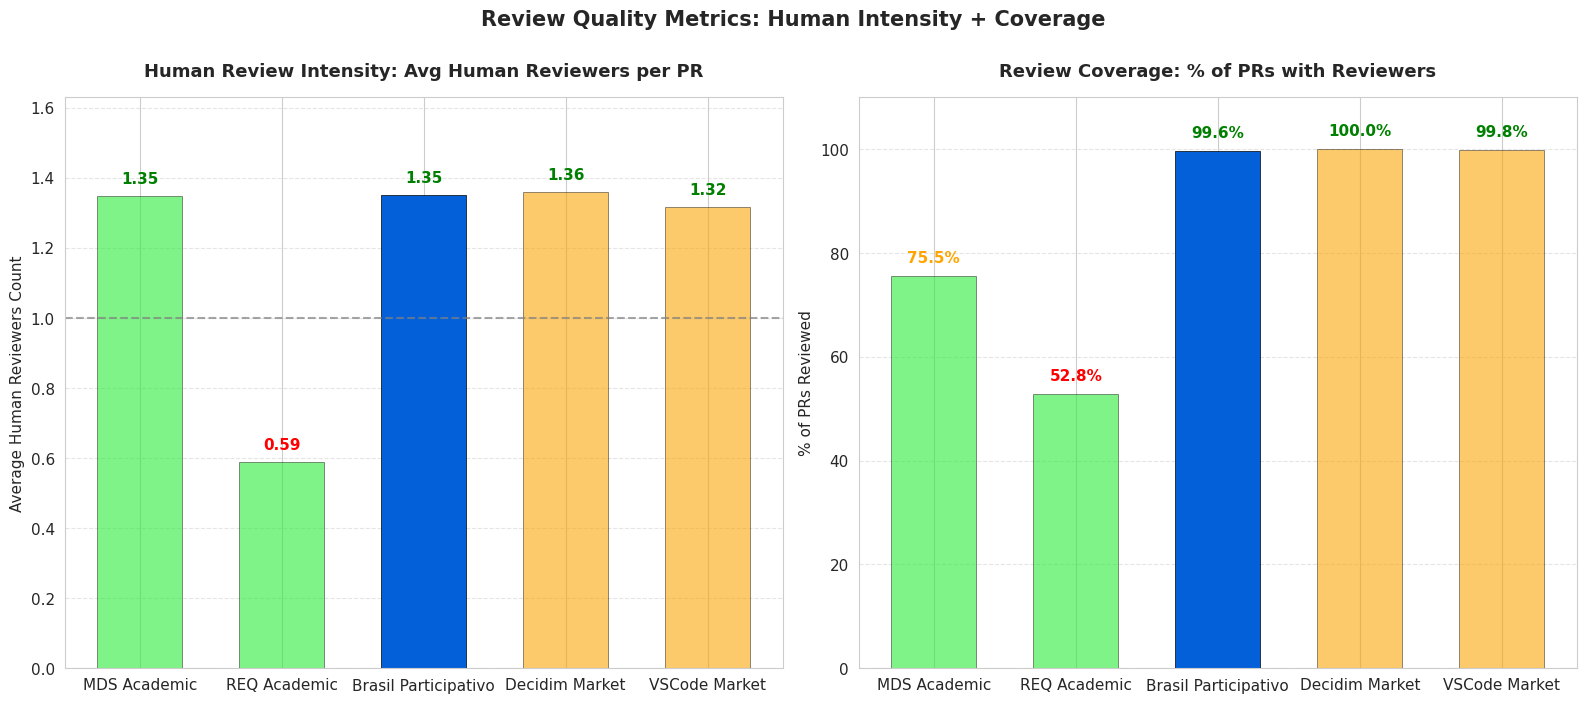

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

x_labels = [mds_title, req_title, org_title, decidim_title, vscode_title]
bar_colors = [DISC_PRIMARY, DISC_PRIMARY, BP_PRIMARY, BENCH_PRIMARY, BENCH_PRIMARY]
bar_alphas = [0.6, 0.6, 1.0, 0.6, 0.6]

y_human_intensity = [human_intensity_mds, human_intensity_req, human_intensity_bp,
                     human_intensity_decidim, human_intensity_vscode]

bars1 = ax1.bar(x_labels, y_human_intensity, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars1, bar_alphas):
    bar.set_alpha(alpha)

ax1.set_title('Human Review Intensity: Avg Human Reviewers per PR', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylabel('Average Human Reviewers Count', fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.5)
ax1.set_ylim(0, max(y_human_intensity) * 1.2)
ax1.axhline(y=1.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

for bar, val in zip(bars1, y_human_intensity):
    height = bar.get_height()
    color = 'red' if val < 1 else 'green'
    ax1.text(bar.get_x() + bar.get_width()/2., height + (max(y_human_intensity) * 0.02),
            f'{val:.2f}', ha='center', va='bottom', fontsize=11, fontweight='bold', color=color)

y_coverage = [coverage_mds, coverage_req, coverage_bp, coverage_decidim, coverage_vscode]

bars2 = ax2.bar(x_labels, y_coverage, color=bar_colors, width=0.6, edgecolor='black', linewidth=0.5)
for bar, alpha in zip(bars2, bar_alphas):
    bar.set_alpha(alpha)

ax2.set_title('Review Coverage: % of PRs with Reviewers', fontsize=13, fontweight='bold', pad=15)
ax2.set_ylabel('% of PRs Reviewed', fontsize=11)
ax2.grid(axis='y', linestyle='--', alpha=0.5)
ax2.set_ylim(0, 110)

for bar, val in zip(bars2, y_coverage):
    height = bar.get_height()
    color = 'green' if val >= 90 else ('orange' if val >= 70 else 'red')
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold', color=color)

plt.suptitle('Review Quality Metrics: Human Intensity + Coverage', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

 <img src="assets/grafo.png" width="1000" />